# Importing Libraries and Dataset

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique, mean, std
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

In [22]:
# importing dataset from github
url = "https://raw.githubusercontent.com/MHBaloch/Machine-Learning-/main/Data.csv" # importing url
dataset = pd.read_csv(url) # reading data fro url
data = dataset # creating dataframe
data.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure


# Data Pre-processing

## Feature Engineering

In [3]:
# creating new columns based on the input variables and described in data description
data['Power'] = data['Rotational speed [rpm]']*data['Torque [Nm]']
data['Overstrain'] = data['Tool wear [min]']*data['Torque [Nm]']
data['Temperature'] = data['Process temperature [K]']-data['Air temperature [K]']
#data_df = data.drop(['Air temperature [K]','Process temperature [K]','Torque [Nm]'], axis=1)
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,66382.8,0.0,10.5
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,65190.4,138.9,10.5
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,74001.2,247.0,10.4
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,56603.5,276.5,10.4
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,56320.0,360.0,10.5


## Data Cleaning

In [4]:
# droping nominal numerical features
df = data.drop(['UDI','Product ID'], axis = 1)
df.head(2)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,M,298.1,308.6,1551,42.8,0,0,No Failure,66382.8,0.0,10.5
1,L,298.2,308.7,1408,46.3,3,0,No Failure,65190.4,138.9,10.5


In [5]:
# total count of failures except No Failure
df_f_type = df[df['Failure Type'].isin(['Power Failure', 'Overstrain Failure', 'Heat Dissipation Failure', 'Tool Wear Failure', 'Random Failures'])]
len(df_f_type)

348

In [6]:
# dropping wrong/ambiguous values
df_failure = df[df['Target']>=1]
df_f_true = df_failure[df_failure['Failure Type']!='No Failure']
df_no_f_true = df[(df['Failure Type']=='No Failure') & (df['Target']<=0)]
df_true = pd.concat([df_f_true,df_no_f_true]).reset_index(drop=True)
data.shape ,df_true.shape

((10000, 13), (9973, 11))

## Data Transformation

In [7]:
# labeling categorical column 'Failure Type' with numerical values.
df_ = df_true.copy()
encoder = LabelEncoder()
df_['Failure Type'] = encoder.fit_transform(df_['Failure Type'])
print(encoder.classes_)
df_.head()

['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Tool Wear Failure']


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,L,298.9,309.1,2861,4.6,143,1,3,13160.6,657.8,10.2
1,L,298.9,309.0,1410,65.7,191,1,3,92637.0,12548.7,10.1
2,L,298.8,308.9,1455,41.3,208,1,4,60091.5,8590.4,10.1
3,L,298.4,308.2,1282,60.7,216,1,2,77817.4,13111.2,9.8
4,L,298.3,308.1,1412,52.3,218,1,2,73847.6,11401.4,9.8


# Data Preparation for Multi-Class Classification

In [8]:
# train_test_split based on Failure Type column and 80:20 ratio
X = df_.drop(columns=['Target', 'Failure Type',"Type"])
y = df_['Failure Type']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=1, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# reason to drop type is that other failure types are not predicted right due to noise
# so it is to reduce dimensionality

((7978, 8), (7978,), (1995, 8), (1995,))

In [9]:
# creating validation subset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6382, 8), (1596, 8), (1995, 8), (6382,), (1596,), (1995,))

## Feature Scaling

In [10]:
# normalizing continuous features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Imbalance Treatment

In [11]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight = "balanced",
                                                classes = np.unique(y_train),
                                                y = y_train)
class_weight

array([17.72777778,  0.2069726 , 23.20727273, 20.58709677, 49.09230769])

In [12]:
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 17.727777777777778,
 1: 0.20697259607588778,
 2: 23.207272727272727,
 3: 20.587096774193547,
 4: 49.09230769230769}

In [13]:
y_train.value_counts()

1    6167
0      72
3      62
2      55
4      26
Name: Failure Type, dtype: int64

# Model Testing and Evaluation

In [ ]:
# baseline model for comparison
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

In [ ]:
# to check if problem can be solved by regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [14]:
# function for model evaluation
from sklearn.multiclass import OneVsRestClassifier
def evaluate(model):
    print('Model Name ', model)
    score_train = cross_val_score(OneVsRestClassifier(model), X_train, y_train, cv=3,scoring = 'f1_macro')
    print('F1_macro: %.3f (%.3f)' % (mean(score_train), std(score_train)))
    score_val = cross_val_score(model, X_val, y_val, cv=3,scoring = 'f1_macro')
    print('F1_macro: %.3f (%.3f)' % (mean(score_val), std(score_val)))

In [15]:
# models
lreg = LogisticRegression(class_weight=class_weight)
svc = SVC(class_weight=class_weight)
dt = DecisionTreeClassifier(class_weight=class_weight)
rf = RandomForestClassifier(class_weight=class_weight)
knn = KNeighborsClassifier()
gb = GradientBoostingClassifier()
nb = GaussianNB()
ada = AdaBoostClassifier()
models=[lreg, svc, dt, rf, knn, gb, nb, ada]

In [16]:
# model evaluation
for model in models:
    evaluate(model)

Model Name  LogisticRegression(class_weight={0: 17.727777777777778, 1: 0.20697259607588778,
                                 2: 23.207272727272727, 3: 20.587096774193547,
                                 4: 49.09230769230769})
F1_macro: nan (nan)
F1_macro: 0.361 (0.031)
Model Name  SVC(class_weight={0: 17.727777777777778, 1: 0.20697259607588778,
                  2: 23.207272727272727, 3: 20.587096774193547,
                  4: 49.09230769230769})
F1_macro: nan (nan)
F1_macro: 0.472 (0.055)
Model Name  DecisionTreeClassifier(class_weight={0: 17.727777777777778,
                                     1: 0.20697259607588778,
                                     2: 23.207272727272727,
                                     3: 20.587096774193547,
                                     4: 49.09230769230769})
F1_macro: nan (nan)
F1_macro: 0.599 (0.028)
Model Name  RandomForestClassifier(class_weight={0: 17.727777777777778,
                                     1: 0.20697259607588778,
             

In [19]:
def report(model):
    print('Model Name ', model)
    model.fit(X_train, y_train)
    y_pre = model.predict(X_test)
    print(classification_report(y_test, y_pre))
    cm = confusion_matrix(y_test, y_pre, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    print('____________________________________________________________________________')

Model Name  LogisticRegression(class_weight={0: 17.727777777777778, 1: 0.20697259607588778,
                                 2: 23.207272727272727, 3: 20.587096774193547,
                                 4: 49.09230769230769})
              precision    recall  f1-score   support

           0       0.17      0.95      0.29        22
           1       1.00      0.75      0.86      1929
           2       0.18      1.00      0.31        16
           3       0.21      0.84      0.33        19
           4       0.02      0.56      0.04         9

    accuracy                           0.76      1995
   macro avg       0.32      0.82      0.36      1995
weighted avg       0.97      0.76      0.84      1995



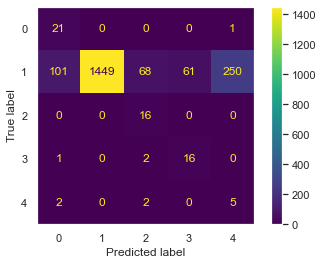

____________________________________________________________________________
Model Name  SVC(class_weight={0: 17.727777777777778, 1: 0.20697259607588778,
                  2: 23.207272727272727, 3: 20.587096774193547,
                  4: 49.09230769230769})
              precision    recall  f1-score   support

           0       0.32      0.95      0.48        22
           1       1.00      0.82      0.90      1929
           2       0.25      0.88      0.38        16
           3       0.24      0.84      0.37        19
           4       0.03      0.67      0.05         9

    accuracy                           0.82      1995
   macro avg       0.37      0.83      0.44      1995
weighted avg       0.97      0.82      0.88      1995



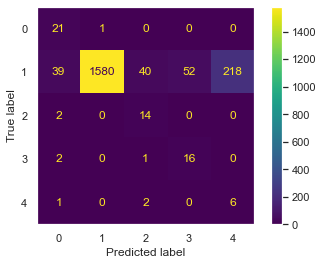

____________________________________________________________________________
Model Name  DecisionTreeClassifier(class_weight={0: 17.727777777777778,
                                     1: 0.20697259607588778,
                                     2: 23.207272727272727,
                                     3: 20.587096774193547,
                                     4: 49.09230769230769})
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        22
           1       0.98      0.89      0.93      1929
           2       0.37      0.81      0.51        16
           3       0.07      0.53      0.12        19
           4       0.05      0.33      0.09         9

    accuracy                           0.88      1995
   macro avg       0.44      0.57      0.41      1995
weighted avg       0.96      0.88      0.91      1995



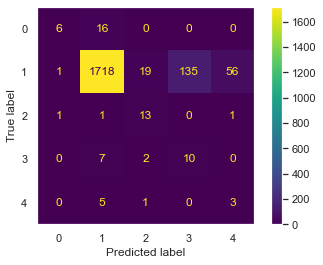

____________________________________________________________________________
Model Name  RandomForestClassifier(class_weight={0: 17.727777777777778,
                                     1: 0.20697259607588778,
                                     2: 23.207272727272727,
                                     3: 20.587096774193547,
                                     4: 49.09230769230769})
              precision    recall  f1-score   support

           0       1.00      0.23      0.37        22
           1       0.98      0.98      0.98      1929
           2       0.53      0.56      0.55        16
           3       0.26      0.53      0.34        19
           4       0.00      0.00      0.00         9

    accuracy                           0.96      1995
   macro avg       0.55      0.46      0.45      1995
weighted avg       0.97      0.96      0.96      1995



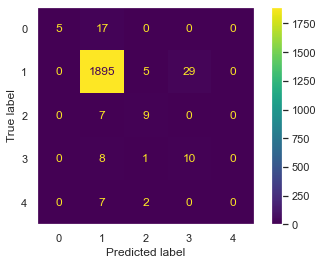

____________________________________________________________________________
Model Name  KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.71      0.23      0.34        22
           1       0.98      0.99      0.99      1929
           2       0.56      0.56      0.56        16
           3       0.46      0.32      0.37        19
           4       0.00      0.00      0.00         9

    accuracy                           0.97      1995
   macro avg       0.54      0.42      0.45      1995
weighted avg       0.96      0.97      0.97      1995



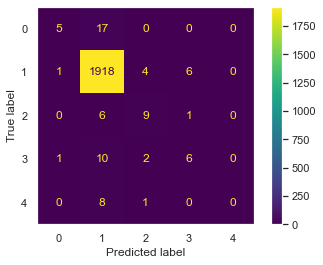

____________________________________________________________________________
Model Name  GradientBoostingClassifier()
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        22
           1       0.98      0.89      0.94      1929
           2       0.17      0.94      0.29        16
           3       0.07      0.53      0.12        19
           4       0.00      0.00      0.00         9

    accuracy                           0.88      1995
   macro avg       0.39      0.53      0.35      1995
weighted avg       0.96      0.88      0.91      1995



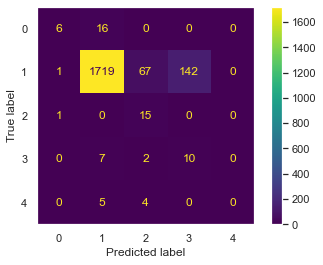

____________________________________________________________________________
Model Name  GaussianNB()
              precision    recall  f1-score   support

           0       0.44      0.50      0.47        22
           1       0.99      0.92      0.95      1929
           2       0.29      0.88      0.44        16
           3       0.09      0.53      0.15        19
           4       0.20      0.33      0.25         9

    accuracy                           0.91      1995
   macro avg       0.40      0.63      0.45      1995
weighted avg       0.97      0.91      0.93      1995



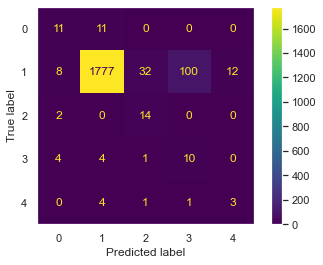

____________________________________________________________________________
Model Name  AdaBoostClassifier()
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.98      0.88      0.93      1929
           2       0.15      1.00      0.26        16
           3       0.07      0.53      0.12        19
           4       0.00      0.00      0.00         9

    accuracy                           0.87      1995
   macro avg       0.24      0.48      0.26      1995
weighted avg       0.95      0.87      0.90      1995



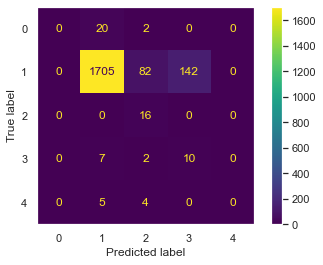

____________________________________________________________________________
Model Name  SGDClassifier(class_weight={0: 17.727777777777778, 1: 0.20697259607588778,
                            2: 23.207272727272727, 3: 20.587096774193547,
                            4: 49.09230769230769})
              precision    recall  f1-score   support

           0       0.24      0.68      0.36        22
           1       1.00      0.93      0.96      1929
           2       0.46      1.00      0.63        16
           3       0.44      0.63      0.52        19
           4       0.06      0.44      0.11         9

    accuracy                           0.93      1995
   macro avg       0.44      0.74      0.52      1995
weighted avg       0.97      0.93      0.95      1995



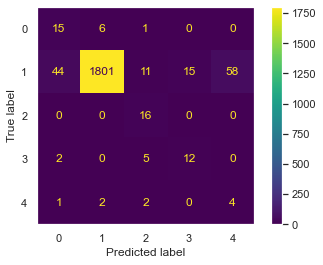

____________________________________________________________________________


In [20]:
for model in models:
    report(model)

Due to high imbalance in dataset, validation subset which is not resampled is not performing well. Therefore, hyperparameter tuning is needed for good performance for above models. Also the recall is very important so the models with good recall score are opted.

# Hyperparameter Tuning

In [ ]:
# Gradient Boosting
grid = {'n_estimators':[10,100,1000], 'max_depth':[3,5,15], 'learning_rate': [0.01, 0.1]}
gb_gs = GridSearchCV(gb, grid, cv=10)
gb_gs.fit(X_train, y_train)
print('Best Parameters:', gb_gs.best_params_)
print('Accuracy:', gb_gs.best_score_)

In [ ]:
# Random Forest
grid = {'n_estimators':[10,100,1000], 'max_depth':[3,5,15], 'class_weight':['balanced']}
rf_gs = GridSearchCV(rf, grid, cv=10)
rf_gs.fit(X_train, y_train)
print('Best Parameters:', rf_gs.best_params_)
print('Accuracy:', rf_gs.best_score_)

In [ ]:
# K-Nearest Neighbors
grid = {'n_neighbors':[1,21,2]}
knn_gs = GridSearchCV(knn, grid, cv=10)
knn_gs.fit(X_train, y_train)
print('Best Parameters:', knn_gs.best_params_)
print('Accuracy:', knn_gs.best_score_)

In [21]:
grid = { 'kernel':['rbf','poly'], 'C':[0.1, 1, 10], 'gamma':[0.1, 0.01, 0.001]}
svc_gs = GridSearchCV(svc, grid, cv=10)
svc_gs.fit(X_train, y_train)
print('Best Parameters:', svc_gs.best_params_)
print('Accuracy:', svc_gs.best_score_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8394005622028935


# Model Evaluation with Optimization

In [ ]:
# models with tuned parameters
# restart kernel after hyperparmeter tuning to avoid overfitting
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=5, random_state=0)
rf = RandomForestClassifier(n_estimators=100, max_depth=15)
knn = KNeighborsClassifier(n_neighbors=4)
svc = SVC(C=10, gamma=0.1, kernel= 'rbf', class_weight=class_weight, random_state=0)

models_best=[svc, rf, knn, gb]

In [ ]:
# model evaluation
# execute evaluate function for this code to run
for model in models_best:
    evaluate(model)

# Model Building

In [23]:
# SVC with one-vs-rest approach and optimized is used as final model for evaluation
final_model = SVC(kernel='rbf', C=10, gamma=0.1, class_weight=class_weight, random_state=0) 
# source (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

## Model Evaluation

In [ ]:
# 3 fold cross validation
score_train = cross_val_score(final_model, X_train, y_train, cv=3, scoring = 'f1_macro')
print('F1_macro: %.3f (%.3f)' % (mean(score_train), std(score_train)))

In [24]:
# restart kernel and clear all outputs if above code line is executed to avoid overfitting
# model validation
# classification report
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.94      0.34        18
           1       1.00      0.76      0.86      1547
           2       0.07      1.00      0.13         7
           3       0.31      0.93      0.46        14
           4       0.03      0.60      0.06        10

    accuracy                           0.76      1596
   macro avg       0.32      0.85      0.37      1596
weighted avg       0.97      0.76      0.84      1596



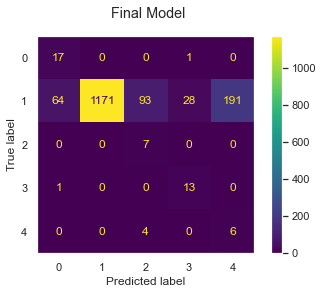

In [25]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.suptitle('Final Model')
plt.show()

The model is performing satisfactory with desired recall. Its the final model and shall now be validated on unseen data.